# High Frequency FX Lead-Lag Relationships

## Contents
1. [Introduction](#introduction)
2. [Low Frequency Data](#low_freq)
3. [High Frequency Data](#high_freq)
    1. [Data Collection](#data_col)
    2. [Data Summary](#data_sum)
    3. [Lead-Lag Analysis](#lead_lag_anal)
    4. [Lead-Lag Implementation](#lead_lag_imp)
    5. [AWS Setup](#aws_setup)
    5. [Results](#results)
4. [Next Steps](#next_steps)

## Introduction <a name="introduction"></a>

The Efficient Market Hypothesis (EMH) suggests that arbitrage opportunities should not exist in financial markets. This does not preclude correlations between related instruments, it merely insists that they are sufficiently contemporaneous that it is impossible to use the price changes of asset X to forecast asset Y and make consistent profits. 

Here we will investigate the existence of a phenomenon that directly contravenes EMH: *lead-lag* relationships. This is where one asset, the *leader*, drives movements in another asset, the *lagger*.

This kind of phenomenon is much simpler to uncover if the two assets are the same (for example, perhaps an asset trades on two different venues). We will be considers the more complex case of two different assets.

## Low Frequency Data <a name="low_freq"></a>

Let's first investigate the relationship between daily EUR/USD and GBP/USD foreign exchange rates. 10 years of data (01/04/2010 - 27/03/2020) were obtained from [Federal Reserve Economic Data](https://fred.stlouisfed.org/categories/94).

In [9]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import requests
import networkx as nx
import os
import gzip
import scipy.stats as stats
from scipy.special import stdtr
from io import StringIO
from itertools import combinations
import random

/Users/Tom/anaconda/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def import_data():
    
    assets = ["GBPUSD", "EURUSD"]
    data_list = []
    
    for asset in assets:
        data = pd.read_csv(asset + ".csv", index_col = 'DATE', parse_dates = True)
        data = data[(data != '.')[asset]]
        data[asset] = data[asset].astype(float)
        data_list.append(data)

    return data_list[0].merge(data_list[1], how="outer", left_index=True, right_index=True).dropna()

In [131]:
def plot_returns():
    
    prices = import_data()
    returns = np.log(prices) - np.log( prices.shift(1) )
    
    returns.loc["2011-01-01":"2011-03-01"].plot(figsize=(15,8))
    
    plt.style.use(['bmh'])
    plt.suptitle("Daily EUR/USD and GBP/USD returns in Jan-March 2011", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Logarithmic Returns")
    
    plt.show()

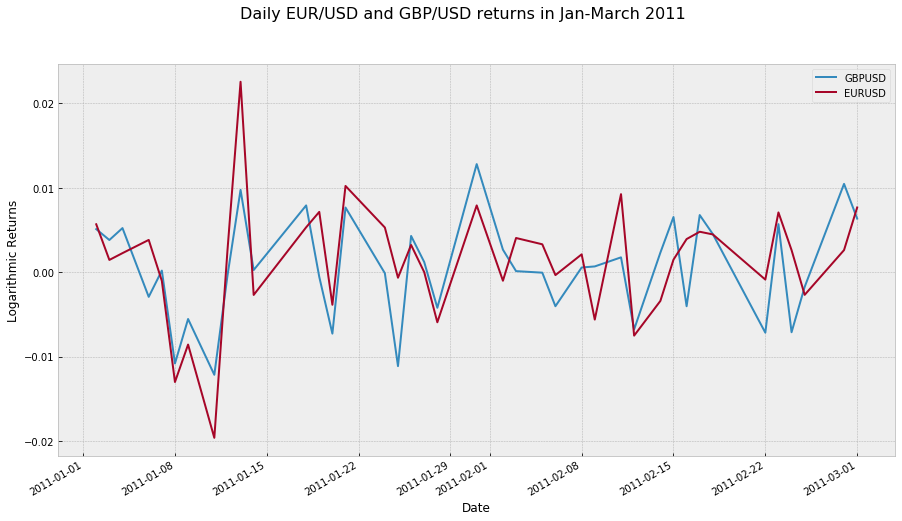

In [132]:
plot_returns()

It is clear from the above plot that these two crosses are related. This also makes intuitive sense since they are both broadly exchange rates between a European currency and the US dollar. This means that they are driven by similar macroeconomic fundamentals.

However, if they each react to these fundamentals at different rates then this would manifest itself as a lead-lag relationship - one driven by confounding variables. Alternatively there may exist a lead-lag relationship of true causation - where price action in one cross directly drives movements in the other. In practice it is very difficult to distinguish between these from the data.

One way to estimate such a relationship between two time series, *X* and *Y*, is to temporally shift one dataset by different amounts, creating *Y'*, and then use some measure of association to assess how related *X* and *Y'* are. Using the Pearson correlation coefficient as a measure arrives at the *cross-correlation*, $\rho_{XY}$ as a function of the lag, $k$:

$$\rho_{XY}(k) = \frac{\text{cov}(X_t, Y_{t+k})}{\sigma_X\sigma_Y} = \frac{\sum_t(X_t - \langle X \rangle)(Y_{t+k} - \langle Y \rangle)}{\sigma_X\sigma_Y}$$

In [129]:
def plot_cross_correlation():
    
    prices = import_data()
    returns = np.log(prices) - np.log( prices.shift(1) )
    returns = returns.dropna()
    
    fig, ax = plt.subplots(figsize=(10,5))
    plt.xcorr(returns["GBPUSD"] - np.mean(returns["GBPUSD"]), 
              returns["EURUSD"] - np.mean(returns["EURUSD"]), normed=True)

    plt.style.use(['bmh'])
    plt.suptitle("EUR/USD vs GBP/USD returns cross-correlation function", fontsize=16)
    plt.xlabel("Lag (trading days)")
    plt.ylabel("correlation")
    plt.xticks(np.arange(-10, 11, 2))
    textstr = "Lag > 0: EUR/USD leads \nLag < 0: GBP/USD leads"
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top')

    plt.show()

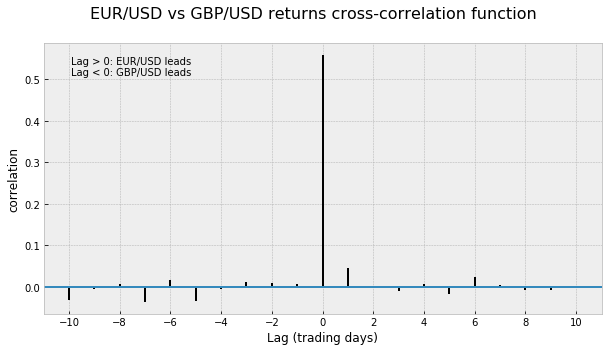

In [130]:
plot_cross_correlation()

The peak at $k=0$ shows that the contemporaneous correlation of the two crosses is around 0.55. However, this dies-off rapidly for non-zero lags resembling a delta function.

The data suggests that, on the scale of daily prices, there is no lead-lag relationship and the EMH holds.

## High Frequency Data <a name="high_freq"></a>

In 2019 the Bank for International Settlements (BIS) estimated that [58%](https://www.bis.org/publ/qtrpdf/r_qt1912g.htm) of spot FX trading was executed electronically. This highly algorithmic market prices-in information very quickly. We are perhaps more likely to uncover lead-lag relationships on shorter time scales.

The academic literature exploring lead-lag relationships in equity markets is quite extensive but [Basnarkov et al.](https://arxiv.org/pdf/1906.10388.pdf) seems to be the only study of FX. They investigate relationships between currencies, commodities and some equity indicies on the minute-timescale. They find few statistically significant relationships between currency pairs, but do uncover some between equity indices and currency pairs. I suspect that minute-timescales are still too coarse to capture FX dynamics.

### Data Collection <a name="data_col"></a>

Adapting code in [this](https://towardsdatascience.com/how-and-why-i-got-75gb-of-free-foreign-exchange-tick-data-9ca78f5fa26c) article I have obtained high frequency FX tick-data for many currency pairs spanning three months (01/01/2019 - 29/03/2019). [Forex Capital Markets](https://www.fxcm.com/uk/about-fxcm/liquidity-providers/) (FXCM) freely provide bid-ask data aggregated from multiple liquidity providers.

First the data is downloaded in weekly-batched zip files. Next these are unpackaged, reformatted and saved into a hierarchical data file: [HDF5](https://www.hdfgroup.org/solutions/hdf5/). This consumes around 30Gb of memory so I would advise writing directly to an external hard-drive.

In [165]:
def download_data(directory, symbols):
    
    years = [2019]
    weeks = list(range(1,14))
    
    for symbol in symbols:
        for year in years:
            for week in weeks:
                url = "https://tickdata.fxcorporate.com/{}/{}/{}.csv.gz".format(symbol, year, week)
                r = requests.get(url, stream=True)
                with open("{}{}_{}_w{}.csv.gz".format(directory, symbol, year, week), 'wb') as file:
                    for chunk in r.iter_content(chunk_size=1024):
                        file.write(chunk)

In [1]:
def reformat_data(hdf5_file):
    
    for file in os.listdir(directory):
        if file.endswith('.gz'):
            print("\nExtracting: {}".format(file))

            # extract gzip file and assign to Dataframe
            codec = 'utf-16'
            f = gzip.GzipFile('{}{}'.format(directory, file))
            data = f.read()
            data_str = data.decode(codec)
            data_pd = pd.read_csv(StringIO(data_str))

            # pad missing zeros in microsecond field
            data_pd['DateTime'] = data_pd.DateTime.str.pad(26, side='right', fillchar='0')

            # assign Datetime column as index
            data_pd.set_index('DateTime', inplace=True)
            
            # want to convert String index to datetime, but pd.to_datetime() is expensive as it has to
            # infer the format for each row. Instead we will determine the format.
            # Note that the format is constant for a given file but can change between files

            # each file spans 5 business day
            # sample the last timestamp and a timestamp from the previous day: usually they will have the
            # same month. Edge cases where these two dates span different months are also handled

            avNumRowsPerDay = round(len(data_pd)/5)
            endTimestamp = data_pd.index[-1]
            previousDayTimestamp = endTimestamp
            i = 1

            while( pd.to_datetime(previousDayTimestamp).date() == pd.to_datetime(endTimestamp).date() ):
                previousDayTimestamp = data_pd.index[-1*i*avNumRowsPerDay]
                i += 1

            if endTimestamp[2] == '/': # year last
                if endTimestamp[0:2] == previousDayTimestamp[0:2]: # month before day
                    data_pd.index = pd.to_datetime(data_pd.index, format="%m/%d/%Y %H:%M:%S.%f")
                elif endTimestamp[3:5] == previousDayTimestamp[3:5]: # month after day
                    data_pd.index = pd.to_datetime(data_pd.index, format="%d/%m/%Y %H:%M:%S.%f")

                # edge cases where these two dates span different months: previousDayTimestamp day must be > 12
                elif int(previousDayTimestamp[0:2]) > 12:  # month after day
                    data_pd.index = pd.to_datetime(data_pd.index, format="%d/%m/%Y %H:%M:%S.%f")
                elif int(previousDayTimestamp[3:5]) > 12:  # month before day
                    data_pd.index = pd.to_datetime(data_pd.index, format="%m/%d/%Y %H:%M:%S.%f")

            elif endTimestamp[4] == '/': # year first
                if endTimestamp[5:7] == previousDayTimestamp[5:7]: # month before day
                    data_pd.index = pd.to_datetime(data_pd.index, format="%Y/%m/%d %H:%M:%S.%f")
                elif endTimestamp[8:10] == previousDayTimestamp[8:10]: # month after day
                    data_pd.index = pd.to_datetime(data_pd.index, format="%Y/%d/%m %H:%M:%S.%f")

                # edge cases where these two dates span different months: previousDayTimestamp day must be > 12
                elif int(previousDayTimestamp[5:6]) > 12:  # month after day
                    data_pd.index = pd.to_datetime(data_pd.index, format="%Y/%d/%m %H:%M:%S.%f")
                elif int(previousDayTimestamp[8:10]) > 12:  # month before day
                    data_pd.index = pd.to_datetime(data_pd.index, format="%Y/%m/%d %H:%M:%S.%f")

            store = pd.HDFStore(hdf5_file)
            symbol = file[:6]
            store.append(symbol, data_pd, format='t') 
            store.flush()
            store.close()

In [2]:
directory = "/Volumes/HardDrive/Mac/data/"
hdf5_file = "/Volumes/HardDrive/Mac/data/FxData.h5"
symbols = ["AUDCAD", "AUDCHF", "AUDJPY", "AUDNZD", "CADCHF", "EURAUD", "EURCHF", "EURGBP", 
           "EURJPY", "EURUSD", "GBPCHF", "GBPJPY", "GBPNZD", "GBPUSD", "NZDCAD", "NZDCHF",
           "NZDJPY", "NZDUSD", "USDCAD", "USDCHF", "USDJPY"]

download_data(directory, symbols)
reformat_data(hdf5_file)

### Data Summary <a name="data_sum"></a>

The FX spot market is OTC and open 24 hours-a-day, 5 days-a-week. The bid-ask data collected has millisecond-precision timestamps. Occasionally a liquidity provider will send a price update despite the bid and ask remaining unchanged. These updates have been removed.

FX rates are usually quoted with a tick-size equivalent to 5-significant figures or 1 pip. Since these prices have been aggregated from liquidity providers they have a higher precision. For this reason, in our study the tick-size for a given cross, $\delta$, will be a tenth of a pip.

We summarise the data by estimating several liquidity statistics that can be usefully compared between crosses:

- the average duration between price updates: $\langle\Delta t\rangle$ (**deltaT_millis**)
- the average absolute percentage change in mid: $\langle|\Delta m| / m\rangle$ (**midPctChange_bps**)
- the average bid-ask spread expressed in tick-size: $\langle s \rangle / \delta$ (**spread_ticks**)
- the fraction of minimum bid-ask spreads (those that equal the tick-size): $\textrm{1}_{s=\delta}$ (**minSpreadPerc**)
- a proxy for mid volatility expressed in tick-size: $\langle|\Delta m|\rangle / \delta$ (**absDeltaMid_ticks**)

These statistics are calculated on a daily basis, then an average across the days is performed. For expediency, these are computed on the first two weeks of data (01/01/2019 - 14/01/2019)

In [4]:
pips = {symbol:0.0001 for symbol in symbols}
pips["AUDJPY"] = 0.01
pips["EURJPY"] = 0.01
pips["GBPJPY"] = 0.01
pips["NZDJPY"] = 0.01
pips["USDJPY"] = 0.01
pips

{'AUDCAD': 0.0001,
 'AUDCHF': 0.0001,
 'AUDJPY': 0.01,
 'AUDNZD': 0.0001,
 'CADCHF': 0.0001,
 'EURAUD': 0.0001,
 'EURCHF': 0.0001,
 'EURGBP': 0.0001,
 'EURJPY': 0.01,
 'EURUSD': 0.0001,
 'GBPCHF': 0.0001,
 'GBPJPY': 0.01,
 'GBPNZD': 0.0001,
 'GBPUSD': 0.0001,
 'NZDCAD': 0.0001,
 'NZDCHF': 0.0001,
 'NZDJPY': 0.01,
 'NZDUSD': 0.0001,
 'USDCAD': 0.0001,
 'USDCHF': 0.0001,
 'USDJPY': 0.01}

In [5]:
def compute_stats(data, tick_size):
    
    data["deltaBid"] = data["Bid"].diff()
    data["deltaAsk"] = data["Bid"].diff()
    data["dropRow"] = (data["deltaBid"].abs() < 1e-10) & (data["deltaAsk"].abs() < 1e-10)
    data = data[~data["dropRow"]].copy()
    
    data["T"] = data.index
    data["deltaT_millis"] = data["T"].diff().dt.total_seconds()*1000            
    data["mid"] = (data["Bid"] + data["Ask"])/2
    data["absDeltaMid"] = data["mid"].diff().abs()
    data["midPctChange"] = data["absDeltaMid"] / data["mid"]
    data["spread"] = data["Ask"] - data["Bid"]
    data["minSpread"] = data["spread"].abs() <= tick_size + 1e-10
    data = data.dropna()
    
    return data

def compute_summary_stats(hdf5_file, symbols, pips, start_date, end_date):
    
    end_date_plus_1 = pd.to_datetime(end_date, format="%Y-%m-%d").date() + datetime.timedelta(days=1)
    
    stats = ["deltaT_millis", "midPctChange_bps", "spread_ticks", "minSpreadPerc", "absDeltaMid_ticks"]
    summary_data = {stat:[] for stat in stats}
    
    with pd.HDFStore(hdf5_file,  mode='r') as store:
        for symbol in symbols:
            print("computing stats for "+ symbol)
            tick_size = pips[symbol]/10

            data = store.select(symbol, where=["index>=" + '"{}"'.format(start_date),
                                               "index<=" + '"{}"'.format(str(end_date_plus_1))])
            data.sort_index(inplace=True)
            data = data[(data.index.weekday !=5) & (data.index.weekday !=6)]
            
            stats = compute_stats(data, tick_size)
            daily_averages = stats.groupby(stats.index.date).mean()
            
            summary_data["deltaT_millis"].append( daily_averages["deltaT_millis"].mean() )
            summary_data["midPctChange_bps"].append( daily_averages["midPctChange"].mean()*100*100 )
            summary_data["spread_ticks"].append( daily_averages["spread"].mean() / tick_size )
            summary_data["minSpreadPerc"].append( daily_averages["minSpread"].mean()*100 )
            summary_data["absDeltaMid_ticks"].append( daily_averages["absDeltaMid"].mean() / tick_size )
    
    return pd.DataFrame(summary_data, index = symbols)

In [13]:
summary_stats = compute_summary_stats(hdf5_file, symbols, pips, "2019-01-01", "2019-01-14")

computing stats for AUDCAD
computing stats for AUDCHF
computing stats for AUDJPY
computing stats for AUDNZD
computing stats for CADCHF
computing stats for EURAUD
computing stats for EURCHF
computing stats for EURGBP
computing stats for EURJPY
computing stats for EURUSD
computing stats for GBPCHF
computing stats for GBPJPY
computing stats for GBPNZD
computing stats for GBPUSD
computing stats for NZDCAD
computing stats for NZDCHF
computing stats for NZDJPY
computing stats for NZDUSD
computing stats for USDCAD
computing stats for USDCHF
computing stats for USDJPY


In [6]:
summary_stats.to_csv("summary_stats.csv", index_label="index")

NameError: name 'summary_stats' is not defined

In [10]:
summary_stats = pd.read_csv("summary_stats.csv")
summary_stats = summary_stats.set_index("index")

In [11]:
summary_stats.style.format({'deltaT_millis': "{:.0f}",
                            'midPctChange_bps': "{:.3f}", 
                            'spread_ticks': "{:.1f}",
                            'minSpreadPerc': "{:.2f}%",
                            'absDeltaMid_ticks': "{:.2f}"})\
                   .background_gradient(cmap='inferno_r', subset = ["deltaT_millis", "midPctChange_bps", 
                                                                   "spread_ticks", "absDeltaMid_ticks"])\
                   .background_gradient(cmap='inferno', subset = ["minSpreadPerc"])\
                   .set_properties(**{'text-align': 'center'})

,deltaT_millis,midPctChange_bps,spread_ticks,minSpreadPerc,absDeltaMid_ticks
index,,,,,
AUDCAD,867,0.100,8.5,1.03%,0.95
AUDCHF,1058,0.130,6.7,1.80%,0.91
AUDJPY,829,0.114,6.7,1.60%,0.87
AUDNZD,862,0.092,11.0,0.28%,0.97
CADCHF,1399,0.123,7.4,1.18%,0.90
EURAUD,509,0.077,12.0,0.82%,1.24
EURCHF,1155,0.081,7.7,1.89%,0.91
EURGBP,913,0.098,5.9,3.30%,0.88
EURJPY,428,0.071,5.4,2.57%,0.87


The table above depicts black as low liquidity (corresponding to larger values, except for **minSpreadPerc** which corresponds to smaller values) and yellow as high liquidity. It is perhaps no surprise that EUR/USD appears to have high liquidity whereas a cross like AUD/NZD scores poorly.

Nevertheless, liquidity can vary quite a lot intraday. The following plots show that, by all measures, EUR/USD becomes much less liquid between 21:00 UTC and 00:00 UTC since this is typically when trading transitions from US to Asia.

In [12]:
def plot_intraday_stats(hdf5_file, symbol, date_string):
    
    end_date = pd.to_datetime(date_string, format="%Y-%m-%d").date() + datetime.timedelta(days=1)
    
    with pd.HDFStore(hdf5_file,  mode='r') as store:
        tick_size = pips[symbol]/10
        data = store.select(symbol, where=["index>=" + '"{}"'.format(date_string),
                                           "index<=" + '"{}"'.format(str(end_date))])
    
    data.sort_index(inplace=True)
    stats = compute_stats(data, tick_size)

    plt.style.use(['bmh'])
    fig = plt.figure( figsize = (15, 30) )
    layout = (5, 1)

    deltaT_ax = plt.subplot2grid(layout, (0, 0))
    midPctChange_ax = plt.subplot2grid(layout, (1, 0))
    spread_ax = plt.subplot2grid(layout, (2, 0))
    minSpreadPerc_ax = plt.subplot2grid(layout, (3, 0))
    absDeltaMid_ax = plt.subplot2grid(layout, (4, 0))

    stats["deltaT_millis"].rolling("10min").mean().plot(ax=deltaT_ax)
    deltaT_ax.set_title(symbol + " " + date_string + ": rolling 10min average of duration between price updates")
    deltaT_ax.set_xlabel("Time")
    deltaT_ax.set_ylabel("milliseconds")

    (stats["midPctChange"]*100*100).rolling("10min").mean().plot(ax=midPctChange_ax)
    midPctChange_ax.set_title(symbol + " " + date_string + ": rolling 10min average of absolute percentage " +
                              "change in mid")
    midPctChange_ax.set_xlabel("Time")
    midPctChange_ax.set_ylabel("bps")

    (stats["spread"]/tick_size).rolling("10min").mean().plot(ax=spread_ax)
    spread_ax.set_title(symbol + " " + date_string + ": rolling 10min average of bid-ask spread expressed " +
                        "in tick-size")
    spread_ax.set_xlabel("Time")
    spread_ax.set_ylabel("ticks")

    (stats["minSpread"]*100).rolling("10min").mean().plot(ax=minSpreadPerc_ax)
    minSpreadPerc_ax.set_title(symbol + " " + date_string + ": rolling 10min average of minimum bid-ask spread " +
                               "frequency (those that equal tick-size)")
    minSpreadPerc_ax.set_xlabel("Time")
    minSpreadPerc_ax.set_ylabel("%")

    (stats["absDeltaMid"]/tick_size).rolling("10min").mean().plot(ax=absDeltaMid_ax)
    absDeltaMid_ax.set_title(symbol + " " + date_string + ": rolling 10min average of absolute change in mid " +
                             "expressed in tick-size")
    absDeltaMid_ax.set_xlabel("Time")
    absDeltaMid_ax.set_ylabel("ticks")

    plt.tight_layout()
    plt.show()

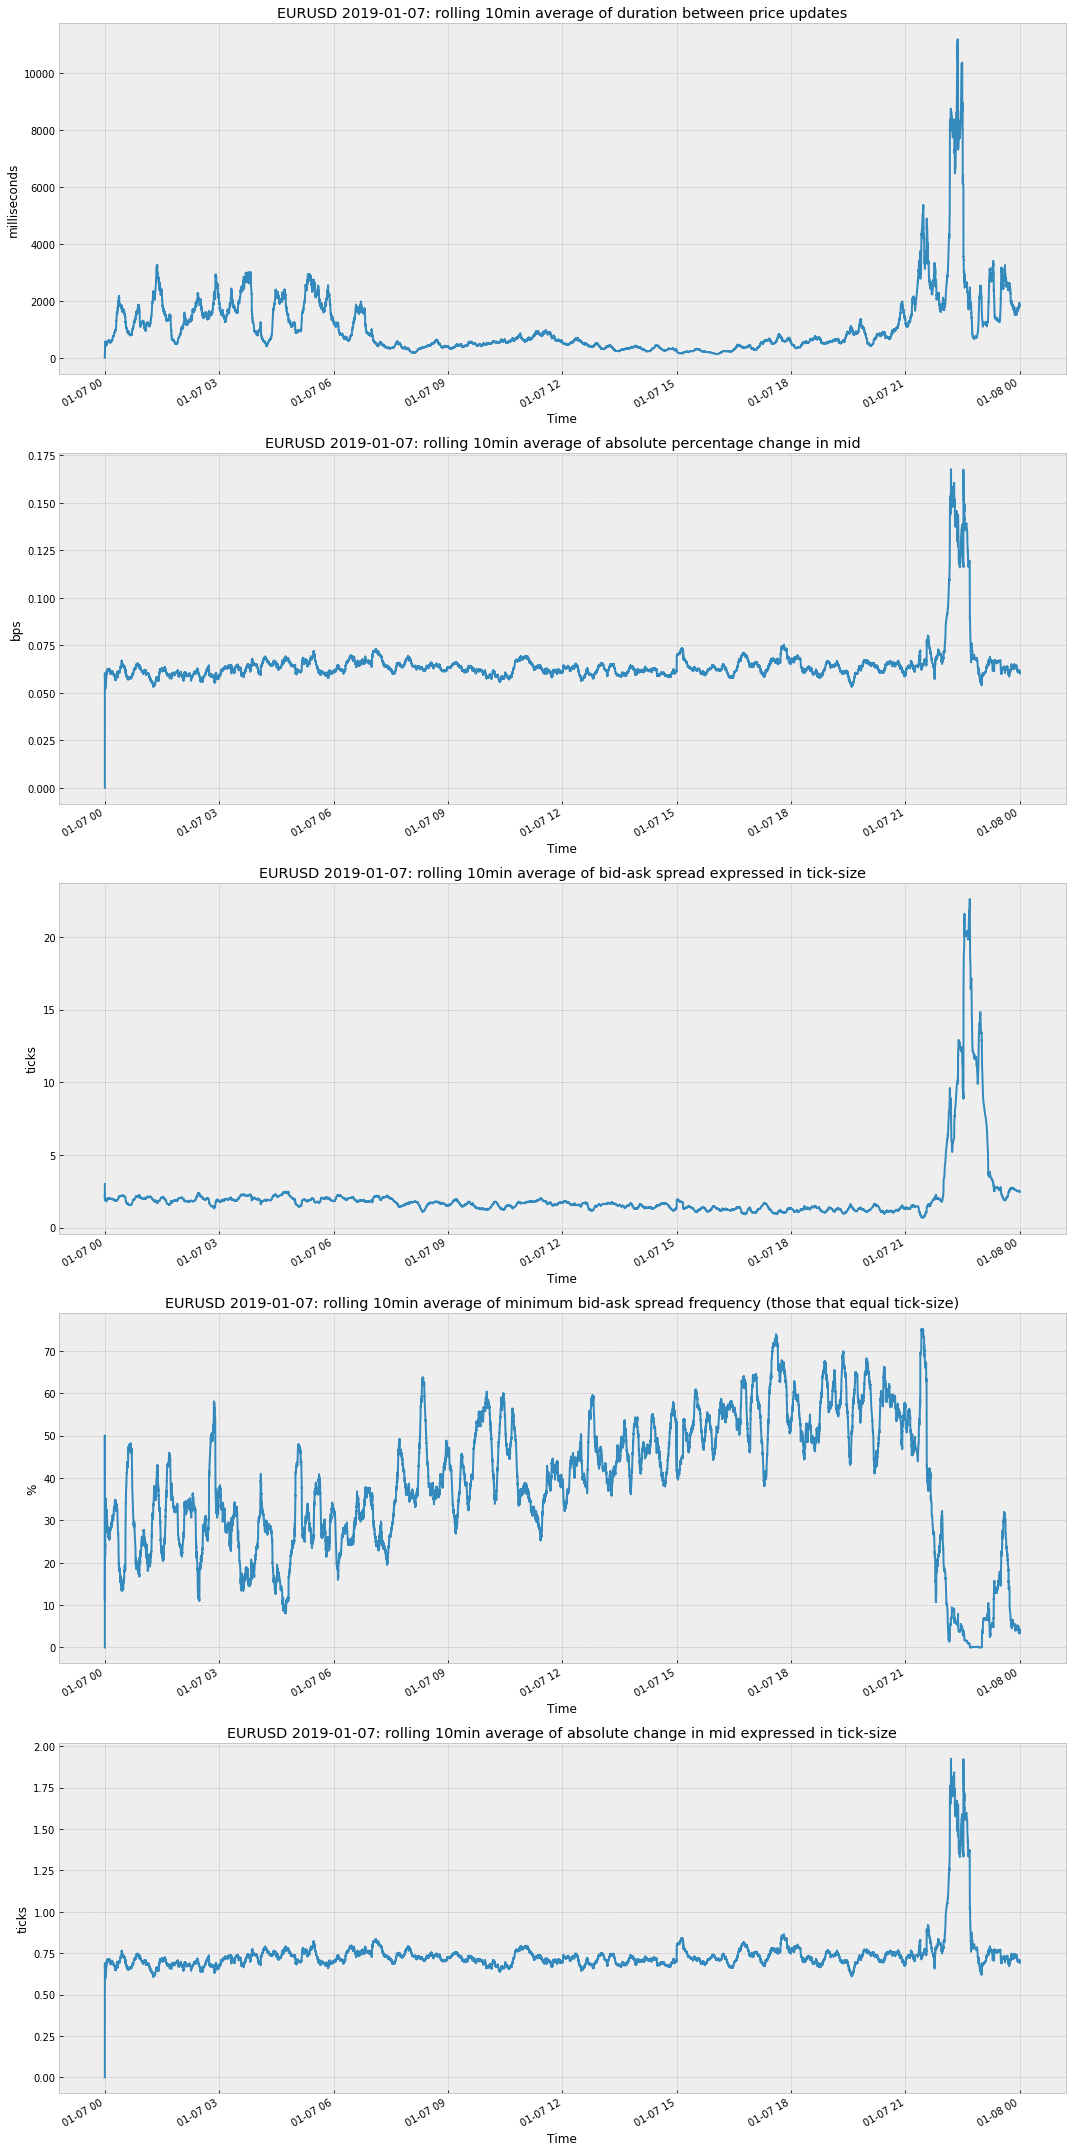

In [13]:
plot_intraday_stats(hdf5_file, "EURUSD", "2019-01-07")

Another interesting avenue is to investigate how much these prices resemble the classical model: Markovian Geometric Brownian Motion. This models logarithmic returns, $r_t$, of an asset price, $S_t$, as samples from a Normal distribution:

$r_t = \ln(S_t) - \ln(S_{t-1}) = \sigma\Delta W$

where $W$ is a Wiener process, that, over a small period of time $dt$, changes with distribution: $\Delta W \sim N(0,dt)$. These returns are independent of one another and therefore make the process memoryless or Markovian. Note, we have assumed returns with zero mean.

In [16]:
def clean_data(raw_data):
    raw_data.sort_index(inplace=True)
    raw_data = raw_data[(raw_data.index.weekday !=5) & (raw_data.index.weekday !=6)]

    raw_data['mid'] = (raw_data['Bid'] + raw_data['Ask'])/2
    raw_data['return'] = raw_data['mid'].diff()
    raw_data['dropRow'] = raw_data['return'].abs() < 1e-10
    raw_data = raw_data[~raw_data["dropRow"]].copy()
    raw_data["log_mid"] = np.log(raw_data['mid'])
    raw_data["log_return"] = raw_data["log_mid"].diff()

    # convert timestamp into milliseconds
    raw_data['timestamp'] = raw_data.index.values.astype(np.int64) // 10 ** 6
    raw_data['dt'] = raw_data['timestamp'].diff()
    raw_data = raw_data.dropna()

    return raw_data

def simulate_gbm(cleaned_data):
    
    means = [0 for i in range(len(cleaned_data))]
    stds = np.power(cleaned_data["dt"], 0.5).values
    
    cleaned_data["log_return_gbm"] = np.random.normal(loc=means, scale=stds)
    cleaned_data["log_return_gbm"] = cleaned_data["log_return_gbm"]*(np.std(cleaned_data["log_return"]) / np.std(cleaned_data["log_return_gbm"]) )
    cleaned_data["log_mid_gbm"] = cleaned_data["log_return_gbm"].cumsum()
    cleaned_data["mid_gbm"] = np.exp(cleaned_data["log_mid_gbm"])
    
def compare_to_gbm(hdf5_file, symbol, date_string):
    
    end_date = pd.to_datetime(date_string, format="%Y-%m-%d").date() + datetime.timedelta(days=1)
    
    with pd.HDFStore(hdf5_file,  mode='r') as store:
        raw_data = store.select(symbol, where=["index>=" + '"{}"'.format(date_string),
                                               "index<=" + '"{}"'.format(str(end_date))])
        
    cleaned_data = clean_data(raw_data)
    simulate_gbm(cleaned_data)
    
    # see how distribution of returns varies by dt: only keep dts that have >= 50 samples
    counts = cleaned_data.groupby(["dt"]).count()
    sufficient_data_deltas = counts[counts["return"] >= 50].index
    sampled_data = cleaned_data[cleaned_data["dt"].isin(sufficient_data_deltas)]
    
    plt.style.use(['bmh'])
    fig = plt.figure( figsize = (15, 15) )
    layout = (3, 1)
    
    returns_hist_ax = plt.subplot2grid(layout, (0, 0))
    returns_mean_ax = plt.subplot2grid(layout, (1, 0))
    returns_std_ax = plt.subplot2grid(layout, (2, 0))
    
    cleaned_data["log_return"].hist(ax=returns_hist_ax, density=True, bins=60, label="empirical")
    cleaned_data["log_return_gbm"].hist(ax=returns_hist_ax, density=True, bins=50, color = "r", alpha = 0.5, label="GBM")
    returns_hist_ax.set_title("Empirical and GBM log-returns distribution for " + symbol + " on " + date_string)
    returns_hist_ax.legend()
    
    sampled_data.groupby(["dt"]).mean()["log_return"].plot(ax=returns_mean_ax, label="empirical")
    sampled_data.groupby(["dt"]).mean()["log_return_gbm"].plot(ax=returns_mean_ax, label="GBM", color = "r")
    returns_mean_ax.set_title("Empirical and GBM log-returns mean as a function of dt: " + symbol + " on " + date_string)
    returns_mean_ax.set_xlabel("dt (milliseconds)")
    returns_mean_ax.legend()

    sampled_data.groupby(["dt"]).apply(lambda x: np.std(x))["log_return"].plot(ax=returns_std_ax, label="empirical")
    sampled_data.groupby(["dt"]).apply(lambda x: np.std(x))["log_return_gbm"].plot(ax=returns_std_ax, label="GBM", color = "r")
    returns_std_ax.set_title("Empirical and GBM log-returns standard-deviation as a function of dt: " + symbol + " on " + date_string)
    returns_std_ax.set_xlabel("dt (milliseconds)")
    returns_std_ax.legend()

    plt.tight_layout()
    plt.show()

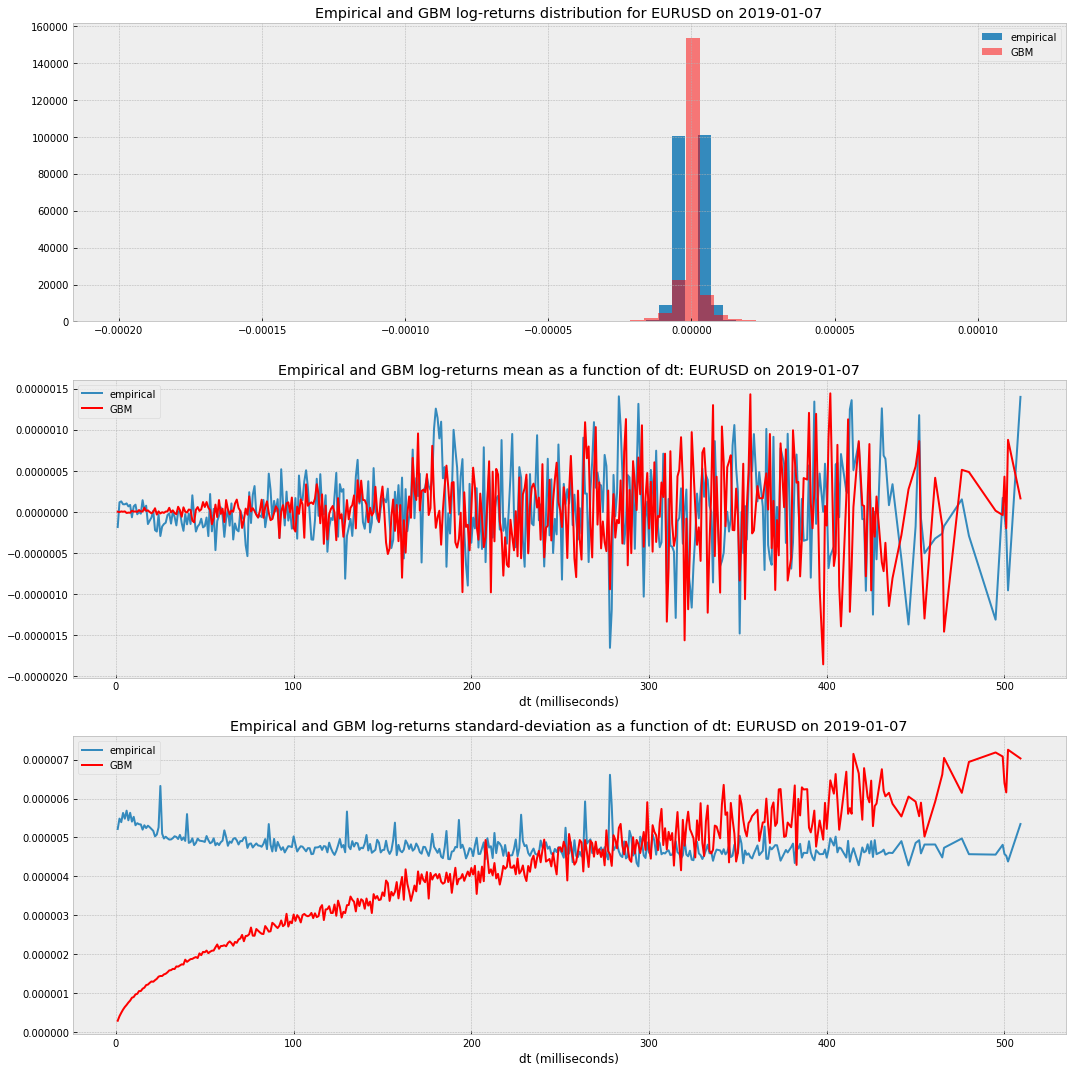

In [17]:
compare_to_gbm(hdf5_file, "EURUSD", "2019-01-07")

The analysis above first removes timestamps at which the return was zero: this causes the bimodal effect in the empirical returns distribution. The width of the gap reflects the minimum tick-size for EUR/USD. Otherwise the distribution is symmetric.

The bottom two plots look at how the return distributions vary as a function of $dt$. A given $dt$ is included if at least 50 samples exist. The empirical data closely resembles that simulated from GBM in the second plot, confirming that the mean of the returns distribution is very close to zero and effectively independent of $dt$.

The third plot, however, shows quite a stark discrepancy. GBM returns have a standard-deviation that grows like the square-root of $dt$: reflecting the intuition that the longer you wait until observing a process, the larger the jump might be compared to its previous value. The real data seem to exhibit exactly the opposite phenomenon. The variance in its returns are actually highest for very short $dt$, and then quickly plateau to a roughly constant level. This could be caused by market-maker thresholding logic and feedback effects in the market.

The plot below shows that a constant volatility model matches the empirical data much better.

In [18]:
def simulate_const_vol(cleaned_data):
    
    std = np.std(cleaned_data["log_return"])
    
    cleaned_data["log_return_const"] = np.random.normal(loc=0, scale=std, size=len(cleaned_data))
    cleaned_data["log_mid_const"] = cleaned_data["log_return_const"].cumsum()

def compare_to_const_vol(hdf5_file, symbol, date_string):
    
    end_date = pd.to_datetime(date_string, format="%Y-%m-%d").date() + datetime.timedelta(days=1)
    
    with pd.HDFStore(hdf5_file,  mode='r') as store:
        raw_data = store.select(symbol, where=["index>=" + '"{}"'.format(date_string),
                                               "index<=" + '"{}"'.format(str(end_date))])
        
    cleaned_data = clean_data(raw_data)
    simulate_const_vol(cleaned_data)
    
    # see how distribution of returns varies by dt: only keep dts that have >= 50 samples
    counts = cleaned_data.groupby(["dt"]).count()
    sufficient_data_deltas = counts[counts["return"] >= 50].index
    sampled_data = cleaned_data[cleaned_data["dt"].isin(sufficient_data_deltas)]

    plt.style.use(['bmh'])
    fig, ax = plt.subplots(figsize=(15,5))
    
    sampled_data.groupby(["dt"]).apply(lambda x: np.std(x))["log_return"].plot(ax=ax, label="empirical")
    sampled_data.groupby(["dt"]).apply(lambda x: np.std(x))["log_return_const"].plot(ax=ax, label="const-vol", color = "r")
    ax.set_title("Empirical and Constant-Vol log-returns standard-deviation as a function of dt: " + symbol + " on " + date_string)
    ax.set_xlabel("dt (milliseconds)")
    ax.legend()

    plt.tight_layout()
    plt.show()

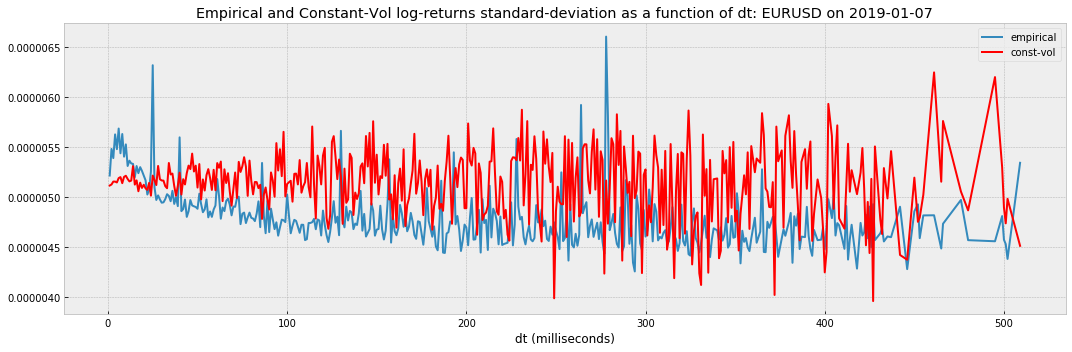

In [19]:
compare_to_const_vol(hdf5_file, "EURUSD", "2019-01-07")

### Lead-Lag Analysis <a name="lead_lag_anal"></a>

The difference between low- and high-frequency data is that the latter is non-synchronous. In our low frequency data each time series had daily aligned timestamps, this is not true for the high-frequency data.

Consider the problem of estimating the covariance of returns between two non-synchronous time-series, *X* and *Y*. Historically this has been tackled by first synchronising the data and then applying standard covariance estimation. One first creates an artificial sampling scheme at pre-determined timestamps, perhaps equally spaced by $h$. Next one synchronises both time-series to the new scheme.

One simple synchronisation technique is called *previous-tick*: select the last available value from the original data. The ramifications of this can be explored by thinking of extreme cases. Suppose that *X* and *Y* tick much slower than the arbitrarily selected *h*. When represented in the new sampling scheme they both remain unchanged for many ticks, equivalently they have zero returns. This means that many of the products in the covariance summation are zero. Now suppose that *X* and *Y* tick much faster than *h*. In this case much of the data is completely ignored by the estimator, missing much of the fine detail. In both scenarios, one can imagine that a correlation computation in the resampled scheme might produce a small value, even if the two time series have truly correlated data generating processes.

[Hayashi & Yoshida](https://www.ms.u-tokyo.ac.jp/~nakahiro/mypapers_for_personal_use/hayyos03.pdf) modelled this situation as two contemporaneously correlated continuous Brownian-motions that were sampled by independent Poisson processes of different intensities. They showed that the previous-tick estimator, $\hat{\rho}_{\text{pt}}$, described above was heavily dependent on the value of $h$. Specifically the estimator was biased, with $\text{E}(\hat{\rho}_{\text{pt}}) \rightarrow 0$ as $h \rightarrow 0 $. They also found similar issues with more nuanced synchronisation techniques based on interpolation.

It was [Epps](https://www.jstor.org/stable/2286325?seq=1) who first noticed that correlations between stock returns tend to diminish as sampling frequency increases, known as the *Epps effect*. [Guillaume et al.](http://ww.long-memory.com/returns/Guillaume-etal1997.pdf) found a similar phenomenon in FX markets. The result from Hayashi & Yoshida may partially explain this.

In the same paper Hayashi & Yoshida go on to propose an unbiased estimator for the linear correlation of returns between non-synchronous time-series, $\hat{\rho}_{\text{HY}}$. Where $\boldsymbol{r}$ and $\boldsymbol{s}$ are the two returns time-series, it can be expressed as:

$$\hat{\rho}_{\text{HY}} = \frac{\sum_{i,j}r_i s_j\textrm{1}_{\{o_{ij}\neq\phi\}}}{\sigma_r\sigma_s}
\qquad\text{where} \,\, o_{ij} = m_i\cap n_j$$

where the indicator function counts a product, $r_is_j$, so long as they overlap: $o_{ij}\neq\phi$. In the diagram below, this would include the products $(r_1 s_1)$, $(r_2 s_1)$, $(r_3 s_1)$, $(r_3 s_2)$, $(r_4 s_2)$ and $(r_4 s_3)$. 
Note that their estimator has no reliance on an arbitrary resampling and wastes no data. In fact, some data points are present in more than one product.

<img src="HY_diagram.png" alt="Drawing" style="width: 500px;"/>

Soon [Yoshida et al.](https://arxiv.org/pdf/1303.4871.pdf) extended their definition, creating an estimator, $\hat{\rho}(k)_{\text{HY}}$, for the whole cross-correlation function. [Huth & Abergel](https://arxiv.org/pdf/1111.7103) modelled non-synchronous but contemporaneously correlated Brownian motions akin to Hayashi & Yoshida. Such time series should have a cross-correlation resembling a delta function. They showed that the naive cross-correlation estimator became increasingly skewed as the sampling rates of the two series diverged. Specifically the more *liquid* of the two series, the one with the highest sampling rate, appeared to be the leader.

In the same paper, Huth & Abergel defined the *Lead-Lag Ratio* (LLR) as the ratio of the cross-correlation function at positive lags to that at negative lags.

$$\text{LLR} = \frac{\sum_{k>0}\hat{\rho}(k)_{\text{HY}}}{\sum_{k<0}\hat{\rho}(k)_{\text{HY}}}$$

For contemporaneously correlated time-series this should be unity since the cross-correlation function should be symmetric. LLR serves as a useful metric to help identify lead-lag relationships in data.

### Lead-Lag Implementation <a name="lead_lag_imp"></a>

We will use an open-source implementation of the Hayashi & Yoshida cross-correlation estimator hosted on [Github](https://github.com/psatyajeet/lead-lag). This package includes a python API whilst the core logic for the estimator (described above) is compiled into C++ using Cython for increased performance. A `LeadLag` object is created by passing the mids for each time-series, but computes the cross-correlation estimator on the returns.

Run the cell below to download and install this package.

In [ ]:
# BASH CELL. Run this to install dependencies

# install git
! sudo yum install git -y
# download lead-lag project from GitHub
! git clone https://github.com/psatyajeet/lead-lag.git
# install gcc: a dependency of lead-lag
! sudo yum -y install gcc
# install lead-lag
! pip install -e lead-lag

In [8]:
def run_save_lead_lag(arr_1_with_ts, arr_2_with_ts, lags, df_name, date_string, verbose=True, multi_threading=False):
    
    ll = lead_lag.LeadLag(arr_1_with_ts, arr_2_with_ts,
                          max_absolute_lag=0,
                          specific_lags=lags,
                          verbose=verbose)
        
    ll.run_inference(multi_threading=multi_threading)

    results_df = ll._contrasts_to_df()
    results_df = results_df.rename(columns={"Contrast": date_string})
    results_df.index = results_df.index.map(int)
    
    LLR_df = pd.DataFrame({date_string : ll.llr}, index=["LLR"])
    results_df = results_df.append(LLR_df)
    results_df.to_csv(df_name, index_label="LagRange")
    
    # no longer needed
    del ll

def run_HY_autocorr(hdf5_file, symbol, date_string, lags):
    
    end_date = pd.to_datetime(date_string, format="%Y-%m-%d").date() + datetime.timedelta(days=1)
    
    with pd.HDFStore(hdf5_file,  mode='r') as store:
        raw_data = store.select(symbol, where=["index>=" + '"{}"'.format(date_string),
                                               "index<=" + '"{}"'.format(str(end_date))])
        
    cleaned_data = clean_data(raw_data)
    simulate_const_vol(cleaned_data)

    arr_with_ts = {}
    arr_with_ts["emp"] = cleaned_data[['timestamp', 'log_mid']].values
    arr_with_ts["sim"] = cleaned_data[['timestamp', 'log_mid_const']].values
    
    for name, data in arr_with_ts.items():
        df_name = symbol + "_" + name + "_auto_results.csv"
        run_save_lead_lag(data, data.copy(), lags, df_name, date_string)
        
        # free variables that are no longer needed
        arr_with_ts[name] = 0

In [9]:
import lead_lag

lags = [10*n for n in range(1,10)] + [100*n for n in range(1,11)]
lags = ( [-1*x for x in lags] + [0] + lags )
lags.sort()

run_HY_autocorr(hdf5_file, "EURUSD", "2019-01-07", lags)

In [29]:
def plot_autocorr(symbol, date_string):
    
    results = {}
    results["empirical"] = get_results(symbol + "_emp_auto_results.csv", date_string)
    results["const-vol"] = get_results(symbol + "_sim_auto_results.csv", date_string)
    
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(figsize=(15,5))
    
    i = 0
    for name, (llr, autocorr) in results.items():
        plt.plot(autocorr.index, list(autocorr), label=name)
        textstr = "LLR_"+ name + " = {:.4f}".format(llr)
        ax.text(0.05, 0.95 - 0.05*i, textstr.format(llr), transform=ax.transAxes, fontsize=10, verticalalignment='top')
        i += 1
    
    plt.suptitle("Empirical and Constant-Vol return auto-correlation function: " + symbol + " on " + date_string, fontsize=14)
    plt.xlabel("Lag (milliseconds)")
    plt.ylabel("correlation")
    
    plt.legend()
    plt.show()

def get_results(file_name, date_string=None):
    
    results = pd.read_csv(file_name)
    results = results.set_index("LagRange")
    
    if date_string!=None:
        results = results[date_string]

    llr = results.loc["LLR"]
    cross_corr = results.iloc[0:-1]
    cross_corr.index = cross_corr.index.map(int)
    
    return (llr, cross_corr)

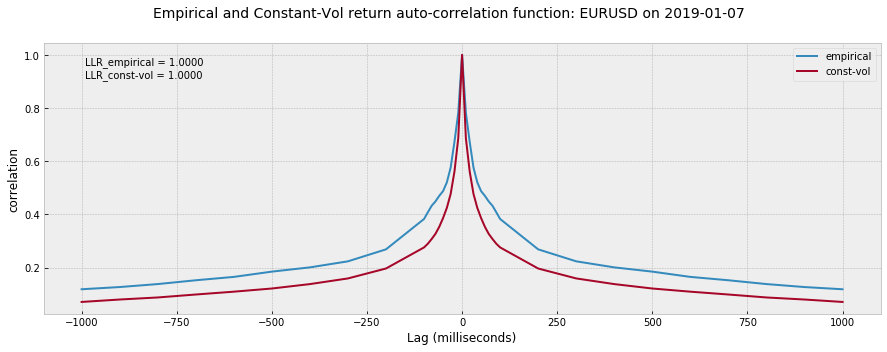

In [30]:
plot_autocorr("EURUSD", "2019-01-07")

The auto-correlation functions plotted above have been computed at the following lags (in milliseconds).

$$[0, 10, 20, ..., 90, 100, 200, 300, ..., 1000]$$

The Constant-Vol model is entirely Markovian or memoryless: its value at a particular time is in no way dependent on previous values. For this reason one should expect its auto-correlation function to resemble a delta function: unity at the origin and zero everywhere else. The observed deviations from this theoretical result are caused by the sampling rate of the time-series. Despite also decaying quickly, at all lags the empirical data has a higher autocorrelation, implying that the underlying process is not  Markovian.

As one might expect, for both processes the LLR is 1 since auto-correlation functions are symmetric by definition.

In [10]:
def run_HY_crosscorr(hdf5_file, pair, date_string, lags):
    
    end_date = pd.to_datetime(date_string, format="%Y-%m-%d").date() + datetime.timedelta(days=1)
    
    raw_data = []
    
    with pd.HDFStore(hdf5_file,  mode='r') as store:
        for symbol in pair:
            raw_data.append( store.select(symbol, where=["index>=" + '"{}"'.format(date_string),
                                                         "index<=" + '"{}"'.format(str(end_date))]) )
            
    ts1 = clean_data(raw_data[0])
    ts2 = clean_data(raw_data[1])
    
    arr_1_with_ts = ts1[['timestamp','log_mid']].values
    arr_2_with_ts = ts2[['timestamp','log_mid']].values
    
    df_name = pair[0] + "_" + pair[1] + "_emp_results.csv"
    run_save_lead_lag(arr_1_with_ts, arr_2_with_ts, lags, df_name, date_string)

In [11]:
run_HY_crosscorr(hdf5_file, ("NZDJPY", "NZDUSD"), "2019-01-07", lags)

Running slow_inference() on (-1000:1000) with 1 thread.
lag: -1000 has been started
Estimation of the cross correlation for lag [-1000] has completed and it took 3.98 seconds.
lag: -900 has been started
Estimation of the cross correlation for lag [-900] has completed and it took 2.47 seconds.
lag: -800 has been started
Estimation of the cross correlation for lag [-800] has completed and it took 2.72 seconds.
lag: -700 has been started
Estimation of the cross correlation for lag [-700] has completed and it took 2.48 seconds.
lag: -600 has been started
Estimation of the cross correlation for lag [-600] has completed and it took 2.55 seconds.
lag: -500 has been started
Estimation of the cross correlation for lag [-500] has completed and it took 2.55 seconds.
lag: -400 has been started
Estimation of the cross correlation for lag [-400] has completed and it took 2.89 seconds.
lag: -300 has been started
Estimation of the cross correlation for lag [-300] has completed and it took 2.39 seconds

In [27]:
def plot_crosscorr(pair, date_string, simulated=False):
    
    if simulated:
        file_suffix = "_sim_results.csv"
        title_prefix = "Simulated "
    else:
        file_suffix = "_emp_results.csv"
        title_prefix = ""
    
    (llr, cross_corr) = get_results(pair[0] + "_" + pair[1] + file_suffix, date_string)
    
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(figsize=(15,5))
    
    plt.plot(cross_corr.index, list(cross_corr))
    
    title = title_prefix + pair[0] + " vs " + pair[1] + " returns cross-correlation function on " + date_string
    plt.suptitle(title, fontsize=14)
    plt.xlabel("Lag (milliseconds)")
    plt.ylabel("correlation")

    textstr = "Lag > 0: " + pair[0] + " leads \nLag < 0: " + pair[1] + " leads \nLLR = {:.4f}".format(llr)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    
    plt.show()

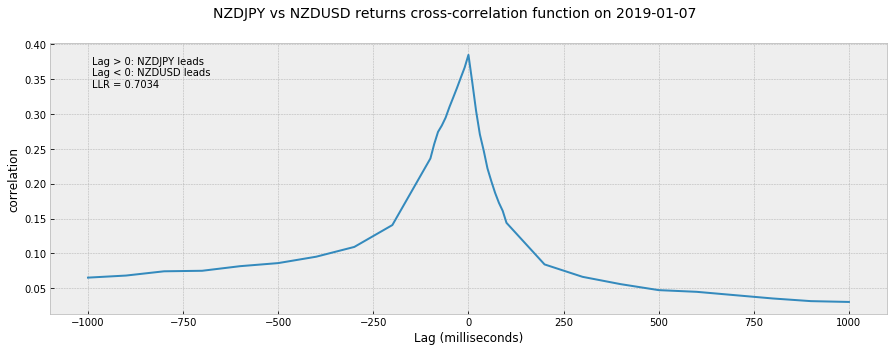

In [31]:
plot_crosscorr(("NZDJPY", "NZDUSD"), "2019-01-07")

There seems to be a distinct difference between the above high-frequency cross-correlation function (asymmetric, slowly decaying) and that constructed earlier on a daily basis (symmetric, delta function). An LLR of 0.7033 indicates that NZD/USD lead NZD/JPY on this particular day.

This value is lower than we would expect for contemporaneously correlated time-series, but is it statistically significant? As of writing, there have been no published results on analytical expressions for the distribution of LLR. This makes it difficult to do a formal hypothesis test to assess the significance of our results. Its distribution is almost certainly some complex function of the sampling of the two time series. However, we can estimate the distribution empirically. Alongside the  estimation that we do for a pair of symbols, we can run another estimation using simulated contemporaneously correlated processes.

We will use the following well-known result. If $R$ and $Z$ are independent and follow identical Normal distributions, then one can construct a new random variable $S$ that also has a Normal distribution and a correlation of $\rho$ to $R$.

$$ R, Z \text{ iid} \sim N(0,\sigma_r^2),\quad
S := \frac{\sigma_s}{\sigma_r}(\rho R + \sqrt{1-\rho^2}Z) \\
\implies S \sim N(0,\sigma_s^2), \quad \text{corr}(R,S) =  \rho$$

We will use the two data sets $R$ and $S$ to model contemporaneously correlated returns. We will initially sample each series every millisecond, and then re-sample each separately to match the true timestamps of the empirical data. Following the previous evidence that a constant volatility model best matches the real data, $\sigma_r$ and $\sigma_s$ will be calibrated accordingly. $\rho$ will be selected as the HY cross-correlation estimator at a lag of zero for that date: the instantaneous correlation. We will be able to use these simulated returns to truly assess the null hypothesis of no genuine lead-lag relationship in the data.

In [39]:
def simulate_corr(r_ts, s_ts, pair, date_string):
    
    earliest_time = min(r_ts.index[0], s_ts.index[0])
    latest_time = max(r_ts.index[-1], s_ts.index[-1])

    new_time_range = pd.date_range(start=earliest_time, end=latest_time+ pd.Timedelta(1, unit="ms"),
                                   freq="1ms" )
    
    num_samples = len(new_time_range)
    rho = get_instantaneous_corr(pair, date_string)
    r_std = np.std(r_ts["log_return"])
    s_std = np.std(s_ts["log_return"])
    
    r_sim_ret = np.random.normal(loc=0.0, scale=r_std, size=num_samples)
    z_sim_ret = np.random.normal(loc=0.0, scale=r_std, size=num_samples)
    s_sim_ret = (s_std/r_std) * (rho * r_sim_ret + np.sqrt(1 - rho ** 2) * z_sim_ret)
        
    resample_sim_returns(r_ts, r_sim_ret, new_time_range)
    resample_sim_returns(s_ts, s_sim_ret, new_time_range)
    
def resample_sim_returns(ts, sim_ret, sim_ret_index):
    
    sim_ret_df = pd.DataFrame({"log_return_const": sim_ret}, index = sim_ret_index)
    sim_ret_df["log_mid_const"] = sim_ret_df.cumsum()
    ts["log_mid_const"] = sim_ret_df.reindex(ts.index)["log_mid_const"]
    
def get_instantaneous_corr(pair, date_string=None, directory=""):
    
    (llr, cross_corr) = get_results(directory + pair[0] + "_" + pair[1] + "_emp_results.csv", date_string)
    return cross_corr.loc[0]

def run_HY_crosscorr_sim(hdf5_file, pair, date_string, lags):
    
    end_date = pd.to_datetime(date_string, format="%Y-%m-%d").date() + datetime.timedelta(days=1)
    
    raw_data = []
    
    with pd.HDFStore(hdf5_file,  mode='r') as store:
        for symbol in pair:
            raw_data.append( store.select(symbol, where=["index>=" + '"{}"'.format(date_string),
                                                         "index<=" + '"{}"'.format(str(end_date))]) )
            
    ts1 = clean_data(raw_data[0])
    ts2 = clean_data(raw_data[1])
    
    simulate_corr(ts1, ts2, pair, date_string)
    
    arr_1_with_ts = ts1[['timestamp','log_mid_const']].values
    arr_2_with_ts = ts2[['timestamp','log_mid_const']].values
    
    df_name = pair[0] + "_" + pair[1] + "_sim_results.csv"
    run_save_lead_lag(arr_1_with_ts, arr_2_with_ts, lags, df_name, date_string)

In [23]:
run_HY_crosscorr_sim(hdf5_file, ("NZDJPY", "NZDUSD"), "2019-01-07", lags)

Running slow_inference() on (-1000:1000) with 1 thread.
lag: -1000 has been started
Estimation of the cross correlation for lag [-1000] has completed and it took 3.65 seconds.
lag: -900 has been started
Estimation of the cross correlation for lag [-900] has completed and it took 2.42 seconds.
lag: -800 has been started
Estimation of the cross correlation for lag [-800] has completed and it took 2.52 seconds.
lag: -700 has been started
Estimation of the cross correlation for lag [-700] has completed and it took 2.97 seconds.
lag: -600 has been started
Estimation of the cross correlation for lag [-600] has completed and it took 2.57 seconds.
lag: -500 has been started
Estimation of the cross correlation for lag [-500] has completed and it took 2.67 seconds.
lag: -400 has been started
Estimation of the cross correlation for lag [-400] has completed and it took 2.76 seconds.
lag: -300 has been started
Estimation of the cross correlation for lag [-300] has completed and it took 2.76 seconds

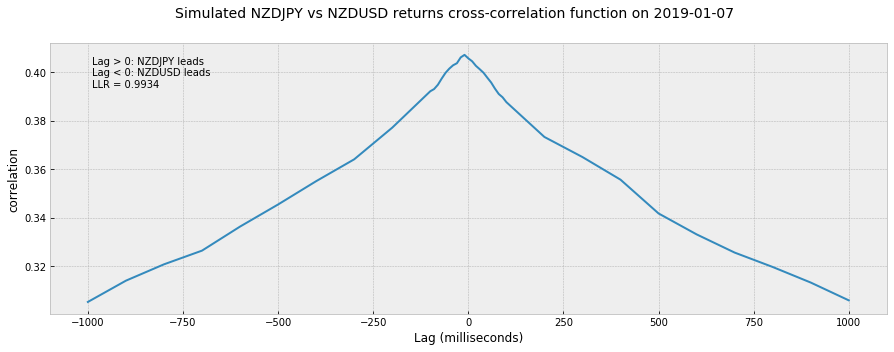

In [24]:
plot_crosscorr(("NZDJPY", "NZDUSD"), "2019-01-07", simulated=True)

As expected, the contemporaneously correlated simulation data is much more symmetric with an LLR much closer to unity. This hints that the NZD/USD lead over NZD/JPY observed above in the real data might be caused by a true lead-lag relationship. More trials are needed to confirm this.

The cross-correlation function itself decays much more slowly than its empirical counterpart. The two data generating processes are merely contemporaneously correlated, with no theoretical correlation at any lags other than zero, and so their cross-correlation function should resemble a delta-function. The reason it doesn't is because each synthetic time-series is initially simulated every millisecond (in order to generate data for every possible point in time) and then heavily down-sampled to match the true timestamps of the empirical data. This down-sampling causes the cross-correlation function to decay more slowly.

The estimator will be computed for every pair of the 21 FX symbols (giving 210 pairs) each business day for the first two months in 2019 (01/01/2019 - 28/02/2019). Updates where the mid remains unchanged, equivalently where the return is zero, have been removed. Otherwise the full 24 hours-a-day, 5 days-a-week data has been retained.

### AWS Setup <a name="aws_setup"></a>

Since so much data needs to be processed I have decided to farm this job out to an AWS EC2 instance. I have detailed the steps required to get setup in the cloud below along with useful links below.

- [Setup EC2 instance](https://medium.com/@alexjsanchez/python-3-notebooks-on-aws-ec2-in-15-mostly-easy-steps-2ec5e662c6c6): This link explains how to create an AWS EC2 instance, download Anaconda and setup a Jupyter server that you can access in your local browser.
    - **Tip 1**: it is probably best not to have your two TCP ports open to the entire internet. Rather than selecting 0.0.0.0/0 as source ports, use the drop-down that allows you to only give access to your local computer.
    - **Tip 2**: if you create your ssh config as described in the article then occasionally your session might drop-out. This will cause your local Jupyter to crash as the ssh tunnel has died. AWS kicks out any stale connections after 60 seconds. This can be fixed by adding the option `ServerAliveInterval 50`, which pings the remote server every 50 seconds to keep the session alive.
    
- [Setup S3 bucket](https://cloud-gc.readthedocs.io/en/latest/chapter03_advanced-tutorial/iam-role.html): EC2 instances are not meant to store large amounts of data locally. You should create an AWS database (called an S3 bucket) to store all of our downloaded FX data. The `save_as_csv()` function below will save data for each symbol to a local .csv file from our HDF5 db. These can then be uploaded into your S3 bucket. Everytime your EC2 instance needs data it will first have to load it locally from S3. Once it is finished using that data it is good practice to delete it. This link explains how to link your EC2 instance and S3 bucket using an IAM role.

In [17]:
def save_as_csv(directory, hdf5_file, symbols, start_date, end_date):
    
    end_date_plus_1 = pd.to_datetime(end_date, format="%Y-%m-%d").date() + datetime.timedelta(days=1)
    
    with pd.HDFStore(hdf5_file,  mode='r') as store:
        for symbol in symbols:
            print("computing stats for "+ symbol)

            data = store.select(symbol, where=["index>=" + '"{}"'.format(start_date),
                                               "index<=" + '"{}"'.format(str(end_date_plus_1))])
    
            print("writing " + symbol)
            data.to_csv(directory + symbol + "_.csv", index_label="DateTime")

In [ ]:
save_as_csv(directory, hdf5_file, symbols, "2019-01-01", "2019-02-28")

To efficiently compute the the cross-correlation function for all 210 pairs of symbols across two months requires some parallelisation. This could be applied at a few different levels:

- **across lags**: have each process compute the cross-correlation at a particular lag, for a particular day, for a particular pair of symbos. This is built into the open-source implementation we are using.
- **across dates**: have each process compute the entire cross-correlation function (for all lags) for a particular day, for a particular pair of symbols.
- **across symbols**: have each process compute the entire cross-correlation function for all dates for a particular pair of symbols.

The in-built threading model doesn't work particularly well when using large datasets. There is only one copy of each time-series for a particular date, for a particular symbol. In this model each process tries to access the same data simultaneously to calculate the cross-correlation at a particular lag. This forces them all to wait in a queue and the end performance is no better than running them in series. I tried producing a copy of each time-series for each individual lag-process to access, but this very quickly ran into memory constraints on even the biggest EC2 instances.

After some tinkering, the second threading model seems to be the most efficient. This is implemented in `run_lead_lags()` below. For a given pair of symbols, we begin by loading their entire data locally from S3. Once each time-series is cached into a DataFrame the local files are deleted. A `LeadLagRunner` object is created for each day (there are 42 business days in the first 2 months of 2019) and these are then distributed to different processes. The `LeadLagRunner` first computes the cross-correlation using the empirical data and then with the simulated data - as the instanteous correlation is required to generate the simulated data. The `distribute_computation()` function then runs at most 25 dates simultaneously, launching a new process only when one has finished. It therefore takes two batches to run all 42 days. Once a pair of symbols has been completed all of the `LeadLagRunner` objects are deleted. This is important as otherwise your instance's RAM will quickly fill up with data that you are already finished with.

In order to run 25 simultaneous processes and be able to hold two months of data for 2 symbols in memory, I spun up an  
[*r5.12xlarge*](https://aws.amazon.com/ec2/pricing/on-demand/) instance. These are optimised to process large data sets in memory. It has 48 virtual cores and 384 Gb of RAM. This took around 12 minutes to compute each pair of symbols, with around a third of this time dedicated to fetching and cleaning the data. Therefore, in total it took around $12\times210 \approx 42$hours to run the whole batch, costing around $42\times \$3=\$126$.

The following three cells should be run in a Jupyter notebook spawned from your EC2 instance.

In [ ]:
# BASH CELL. Run this to install dependencies

# install git
! sudo yum install git -y
# download lead-lag project from GitHub
! git clone https://github.com/psatyajeet/lead-lag.git
# install gcc: a dependency of lead-lag
! sudo yum -y install gcc
# install lead-lag
! pip install -e lead-lag
# install boto3: required to access data in S3 bucket
! pip install boto3
# install htop: to monitor system performance
! sudo yum install htop -y

In [ ]:
# import dependencies
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import requests
import os
import boto3
import gzip
from io import StringIO
import tables as tb
from itertools import combinations
import lead_lag
from multiprocessing import Process, Queue
import time

bucket_name = "INSERT_YOUR_BUCKET_NAME"

# these utility functions help us access data in S3 bucket
def loadS3_to_local(path):
    with open(path,'wb') as f:
        return boto3.Session().resource("s3").Bucket(bucket_name).Object(path).download_fileobj(f)

def delete_from_local(path):
    os.remove(path)
    
def write_local_to_S3(path):
    with open(path,'rb') as f:
        return boto3.Session().resource("s3").Bucket(bucket_name).Object(path).upload_fileobj(f)

In [22]:
class LeadLagRunner:

    def __init__(self, ts1, ts2, lags, date, verbose=False):
        self.ts1 = ts1
        self.ts2 = ts2
        self.lags = lags
        self.date = date
        self.verbose = verbose
        self.results = {}

    def run(self):
        self._run_empirical()
        self._run_simulated()
        
    def get_results(self):
        return self.results

    def _run_empirical(self):

        self._run_lead_lag("emp",
                           self.ts1[['timestamp','log_mid']].values,
                           self.ts2[['timestamp','log_mid']].values)

    def _run_simulated(self):

        self._generate_sim_data()

        self._run_lead_lag("sim",
                           self.ts1[['timestamp','log_mid_sim']].values,
                           self.ts2[['timestamp','log_mid_sim']].values)

    def _generate_sim_data(self):

        earliest_time = min(self.ts1.index[0], self.ts2.index[0])
        latest_time = max(self.ts1.index[-1], self.ts2.index[-1])

        new_time_range = pd.date_range(start=earliest_time, end=latest_time+ pd.Timedelta(1, unit="ms"),
                                       freq="1ms" )

        num_samples = len(new_time_range)
        rho = self.results["emp"]["correlations"].loc[0,"Contrast"]
        ts1_std = np.std(self.ts1["log_return"])
        ts2_std = np.std(self.ts2["log_return"])

        ts1_sim_ret = np.random.normal(loc=0.0, scale=ts1_std, size=num_samples)
        z_sim_ret = np.random.normal(loc=0.0, scale=ts1_std, size=num_samples)
        ts2_sim_ret = (ts2_std/ts1_std) * (rho * ts1_sim_ret + np.sqrt(1 - rho ** 2) * z_sim_ret)

        self._resample_sim_data(self.ts1, ts1_sim_ret, new_time_range)
        self._resample_sim_data(self.ts2, ts2_sim_ret, new_time_range)

    def _resample_sim_data(self, ts, sim_ret, sim_ret_index):
        
        sim_ret_df = pd.DataFrame({"log_return_sim": sim_ret}, index = sim_ret_index)
        sim_ret_df["log_mid_sim"] = sim_ret_df.cumsum()
        ts["log_mid_sim"] = sim_ret_df.reindex(ts.index)["log_mid_sim"]

    def _run_lead_lag(self, name, arr_1_with_ts, arr_2_with_ts):

        ll = lead_lag.LeadLag(arr_1_with_ts, arr_2_with_ts,
                              max_absolute_lag=0,
                              specific_lags=self.lags,
                              verbose=False)

        ll.run_inference(multi_threading=False)
        df = ll._contrasts_to_df()
        df.index = df.index.map(int)

        self.results[name] = {"date": self.date,
                              "correlations": df,
                              "LLR": ll.llr}

        del ll

In [23]:
def run_lead_lags(symbols, start_date, end_date, lags):
    
    end_date_plus_1 = pd.to_datetime(end_date, format="%Y-%m-%d").date() + datetime.timedelta(days=1)
    
    for pair in combinations(symbols, 2):        
        start = time.time()
        print("***** " + pair[0] + "_" + pair[1] + " : starting at: " + 
              time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start)))
        
        ts1 = fetch_and_clean_data(pair[0], start_date, str(end_date_plus_1))
        ts2 = fetch_and_clean_data(pair[1], start_date, str(end_date_plus_1))
        
        lead_lag_runners = []
        for date in np.unique(ts1.index.date):
            print("\tinitialising data for: " + str(date))
            
            ts1_today = ts1[ts1.index.date == date]
            ts2_today = ts2[ts2.index.date == date]
    
            lead_lag_runners.append( LeadLagRunner(ts1_today, ts2_today, lags, date) )
            
        outputs = distribute_computation(lead_lag_runners)
        # no longer need these as we have the output
        del lead_lag_runners
                
        corr_df = pd.DataFrame({}, index=[int(lag) for lag in lags])
        corr_df.index.name = "Lags"
        LLR_df = pd.DataFrame({}, index=["LLR"])
        
        all_results = {}
        all_results["emp"] = {"corr": corr_df, "llr": LLR_df}
        all_results["sim"] = {"corr": corr_df.copy(), "llr": LLR_df.copy()}
        
        for output in outputs:
            for version in ["emp", "sim"]:
                this_output = output[version]
                all_results[version]["corr"][this_output["date"]] = this_output["correlations"]
                all_results[version]["llr"][this_output["date"]] = this_output["LLR"]
                
        for version, results in all_results.items():
            corr_df = results["corr"]
            LLR_df = results["llr"]

            results_df = corr_df.append(LLR_df)
            file_name = pair[0] + "_" + pair[1] + "_" + version + "_results.csv"
            results_df.to_csv(file_name, index_label="LagRange")
            write_local_to_S3(file_name)

        end = time.time()
        print("***** " + pair[0] + "_" + pair[1] + " : finished at: " +
              time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end)) + 
              " this took: " + str((end-start)/60) + " mins")
            
def fetch_and_clean_data(symbol, start_date, end_date):
    
    loadS3_to_local(symbol + "_.csv")
    ts = pd.read_csv(symbol + "_.csv", index_col = 'DateTime', parse_dates = True)
    delete_from_local(symbol + "_.csv")
    
    ts.sort_index(inplace=True)
    ts = ts[(ts.index >= start_date) & (ts.index <= end_date)]
    
    ts['mid'] = (ts['Bid'] + ts['Ask'])/2
    ts['return'] = ts['mid'].diff()
    ts['dropRow'] = ts['return'].abs() < 1e-10
    ts = ts[~ts["dropRow"]].copy()
    ts["log_mid"] = np.log(ts['mid'])
    ts["log_return"] = ts["log_mid"].diff()

    ts = ts[(ts.index.weekday !=5) & (ts.index.weekday !=6)]
    # convert timestamp into milliseconds
    ts['timestamp'] = ts.index.values.astype(np.int64) // 10 ** 6
    ts = ts.dropna()
    
    return ts

def distribute_computation(lead_lag_runners):
    
    processes = []
    output_q = Queue()
    outputs = []
    max_num_processes = 15
    
    def check_for_done(processes):
        for i, p in enumerate(processes):
            p.join()
            if ~p.is_alive():
                outputs.append(output_q.get())
                print("\tPID: " + str(p.pid) + " has finished! Starting a new process!\n")
                return True, i
        return False, False
    
    def parallel_func(ll_runner, output_q):
        print("\t** running computation for date: " + str(ll_runner.date) + " **\n")
        
        ll_runner.run()
        output_q.put(ll_runner.get_results())
        
        print("\t** finished computation for date: " + str(ll_runner.date) + " **\n")
    
    for ll_runner in lead_lag_runners:
        p = Process(target=parallel_func, args=[ll_runner, output_q])
        p.start()
        print("\tStarting PID: " + str(p.pid) + "\n")
        processes.append(p)
        
        if len(processes) == max_num_processes:
            wait = True
            while wait:
                done, num = check_for_done(processes)
                if done:
                    processes.pop(num)
                    wait = False
                else:
                    time.sleep(0.5)
    
    # wait until all processes are complete
    for p in processes:
        p.join()
        outputs.append(output_q.get())
    
    return outputs

In [ ]:
lags = [10*n for n in range(1,10)] + [100*n for n in range(1,11)]
lags = ( [-1*x for x in lags] + [0] + lags )
lags.sort()

run_lead_lags(symbols, "2019-01-01", "2019-02-28", lags)

### Results <a name="results"></a>

The plots below show the average daily cross-correlation function across all 42 days along with its $2\sigma$ uncertainty range. The distribution of LLRs is also illustrated with a fitted Normal distribution for comparison.

Now with more evidence, it seems that the NZD/USD lead over NZD/JPY is a stable phenomenon that persists throughout the time period. The simulated data generate a tight, $\sigma\approx0.01$, LLR distribution with a mean very close to 1. Whereas the empirical data has a much lower mean and more diffuse distribution: $\sigma \approx 0.05$

In [72]:
def plot_all_crosscorr(pair, simulated=False):
    
    if simulated:
        file_suffix = "_sim_results.csv"
        title_prefix = "Simulated "
    else:
        file_suffix = "_emp_results.csv"
        title_prefix = ""
    
    (llr, cross_corr) = get_results("results/" + pair[0] + "_" + pair[1] + file_suffix)
    
    plt.style.use(['bmh'])
    fig = plt.figure( figsize = (15, 10) )
    layout = (2, 1)

    cross_corr_ax = plt.subplot2grid(layout, (0, 0))
    llr_ax = plt.subplot2grid(layout, (1, 0))

    means = cross_corr.mean(axis=1)
    one_sigma = cross_corr.std(axis=1)
    upper = means + one_sigma
    lower = means - one_sigma
    cross_corr_ax.plot(cross_corr.index, list(means))
    cross_corr_ax.fill_between(cross_corr.index, list(lower), list(upper), alpha=0.2)

    cross_corr_title = title_prefix + pair[0] + " vs " + pair[1] + " returns daily cross-correlation function from 2019-01-01 : 2019-02-28"
    cross_corr_ax.set_title(cross_corr_title)
    cross_corr_ax.set_xlabel("Lag (milliseconds)")
    cross_corr_ax.set_ylabel("correlation")

    cross_corr_textstr = "Lag > 0: " + pair[0] + " leads \nLag < 0: " + pair[1] + " leads"
    cross_corr_ax.text(0.05, 2.0, cross_corr_textstr, transform=llr_ax.transAxes, fontsize=10, verticalalignment='top')
    
    llr_mean = llr.mean()
    llr_std = llr.std()
    fit_llrs = np.arange(llr.min(), llr.max() + 0.001, 0.001)
    fit = stats.norm.pdf(fit_llrs, llr_mean, llr_std)
    
    llr_ax.hist(list(llr), normed=True)
    llr_ax.plot(fit_llrs, fit, '-')
    llr_title = title_prefix + pair[0] + " vs " + pair[1] + " LLR distribution"
    llr_ax.set_title(llr_title)
    llr_ax.set_xlabel("LLR")

    llr_textstr = "Mean: {:.4f}".format(llr_mean) + "\nStd:    {:.4f}".format(llr_std) + "\nDays: {}".format(len(llr))
    llr_ax.text(0.05, 0.9, llr_textstr, transform=llr_ax.transAxes, fontsize=10, verticalalignment='top')

    plt.show()

/Users/Tom/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


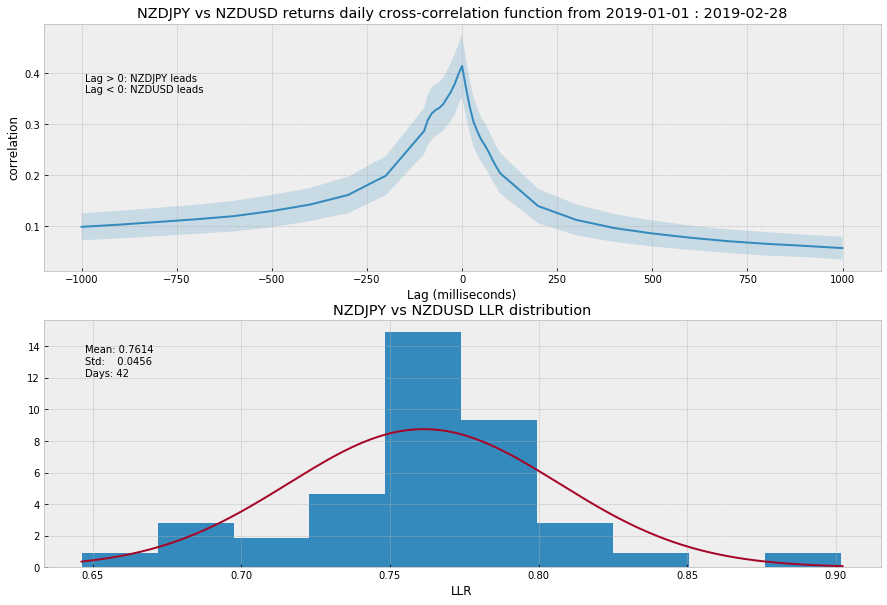

In [73]:
plot_all_crosscorr(("NZDJPY", "NZDUSD"))

/Users/Tom/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


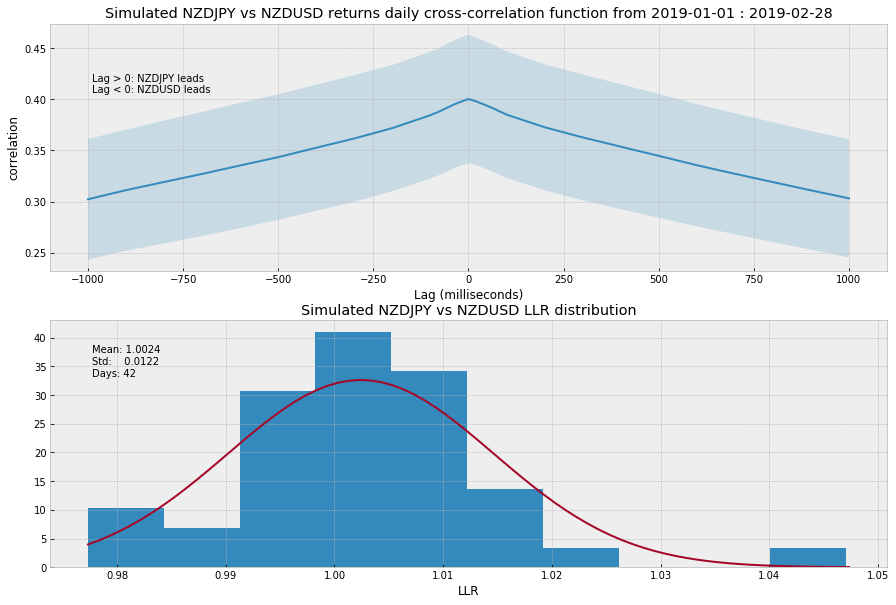

In [74]:
plot_all_crosscorr(("NZDJPY", "NZDUSD"), simulated=True)

We can use Welch's *t*-test to assess whether the two LLR distributions, which have different variances, have statistically different means. The hypothesis test assumes that both underlying distributions are Normal. This assumption appears to be reasonable for the simulated LLRs, but less so for the empirical distribution which appears more leptokurtic. Nevertheless, we can appeal to the Central Limit Theorem which will enforce this assumption for us for a sufficiently large sample size.

$$t = \frac{\mu_1 - \mu_2}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{n}}}, \qquad \nu\approx\frac{(n-1)(\sigma_1^2 + \sigma_2^2)^2}{\sigma_1^4 + \sigma_2^4}$$

Welch's result says that the random variable *t* follows a *t*-distribution with degrees-of-freedom approximated by $\nu$, where $n$ is the number of trials from each distribution.

In [34]:
def is_significant(pair, alpha=0.05, verbose=False):
    
    (llr_emp, cross_corr_emp) = get_results("results/" + pair[0] + "_" + pair[1] + "_emp_results.csv")
    (llr_sim, cross_corr_sim) = get_results("results/" + pair[0] + "_" + pair[1] + "_sim_results.csv")

    emp_bar = llr_emp.mean()
    emp_var = llr_emp.var(ddof=1)

    sim_bar = llr_sim.mean()
    sim_var = llr_sim.var(ddof=1)

    n = len(llr_emp)

    t = (emp_bar - sim_bar) / np.sqrt((emp_var + sim_var)/n)
    dof = (n-1)*(emp_var + sim_var)**2 / (emp_var**2 + sim_var**2)
    two_tailed_p_value = 2*stdtr(dof, -np.abs(t))
    
    if verbose:
        print("-------------------------------------------------------------------------------------------------------")   
        print("Welch's t-Test:\n")
        print("H0: empirical and simulated LLR distributions have the same mean\n")
        
        if two_tailed_p_value < alpha:
            print("We reject H0. We have reason to believe that {} exhibit a lead-lag relationship \n".format(pair))
        else:
            print("We cannot reject H0. We have no reason to believe that {} exhibit a lead-lag relationship\n".format(pair))
        print("-------------------------------------------------------------------------------------------------------")
    
    return two_tailed_p_value < alpha

In [35]:
is_significant(("NZDJPY", "NZDUSD"), verbose=True)

-------------------------------------------------------------------------------------------------------
Welch's t-Test:

H0: empirical and simulated LLR distributions have the same mean

We reject H0. We have reason to believe that ('NZDJPY', 'NZDUSD') exhibit a lead-lag relationship 

-------------------------------------------------------------------------------------------------------


True

It seems that the difference between the empirical and simulated LLR distribution is indeed statistically significant, confirming the NZD/USD lead over NZD/JPY.

We can try to display all of the relevant relationships in one plot. The following network uses nodes to represent symbols and edges to represent both the direction and strength of a lead-lag relationship. We display statistically significant relationships that have an instantaneous correlation greater than 20%. The closer the nodes are, the higher their correlation.

This helps us to identify candidate pairs for a lead-lag arbitrage strategy: high correlation (so that if one symbol ticks up, you can be reasonably sure that the other will) with a high LLR (indicating that these two events are temporally spaced apart and not instantaneous).

The network indicates that the following relationships might be fruitful:

- NZD/USD lead over GBP/NZD and NZD/JPY 
- EUR/CHF lead over EUR/JPY and EUR/USD

In [106]:
def plot_llr_network(symbols):
    
    # llr directed network: edges used in final plot
    # - edge weight = LLR     
    # - edge direction = lead -> lag    
    
    # correlation undirected network: node positions used in final plot
    # - edge weight = correlation
    
    llr_graph = nx.DiGraph()
    corr_graph = nx.Graph()
    min_rho = 0.2
    
    for pair in combinations(symbols, 2):
        
        for symbol in pair:
            llr_graph.add_node(symbol)
            corr_graph.add_node(symbol)

        av_rho = get_instantaneous_corr(pair, directory="results/").mean()
        corr_graph.add_edge(pair[0], pair[1], weight=av_rho)

        # only keep pairs that are sufficiently correlated & have a significant lead-lag relationship
        if((abs(av_rho) < min_rho) or (not is_significant(pair))):
            continue
            
        (llr_emp, cross_corr_emp) = get_results("results/" + pair[0] + "_" + pair[1] + "_emp_results.csv")
        av_llr = llr_emp.mean()

        if(av_llr > 1):
            (lead, lag) = pair
        else:
            (lag, lead) = pair
            av_llr = 1/av_llr
        
        llr_graph.add_edge(lead, lag, weight=av_llr)
    
    node_positions = nx.spring_layout(corr_graph)
    label_positions = { k: (v[0], v[1]+0.05) for k, v in node_positions.items() }
    edges, weights = zip(*nx.get_edge_attributes(llr_graph, 'weight').items())
    
    fig, ax = plt.subplots(figsize=(20,20))
    cmap = plt.cm.Blues
    
    nodes = nx.draw_networkx_nodes(llr_graph, node_positions, node_color='k', alpha=0.5, node_size=400)
    labels = nx.draw_networkx_labels(llr_graph, label_positions, font_size=20)
    nx.draw_networkx_edges(llr_graph, node_positions, edgelist=edges, arrowsize=30, width=2, edge_color=weights, edge_cmap=cmap)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation = "horizontal")
    cbar.ax.tick_params(labelsize=20)
    
    title = "A network showing pairs with an instantaneous correlation greater than {:.0f}".format(100*min_rho)\
                + "% and a statistically significant lead-lag relationship"
    ax.set_title(title, fontsize=20)
    
    ax.text(0.05, 0.95, "- higher correlated nodes are closer together", transform=ax.transAxes, fontsize=20, verticalalignment='top')
    ax.text(0.05, 0.92, "- edge strength: LLR", transform=ax.transAxes, fontsize=20, verticalalignment='top')
    ax.text(0.05, 0.89, "- edge direction: lead --> lag", transform=ax.transAxes, fontsize=20, verticalalignment='top')

    plt.grid(False)
    ax.patch.set_alpha(0)
    plt.tight_layout()
    plt.show()

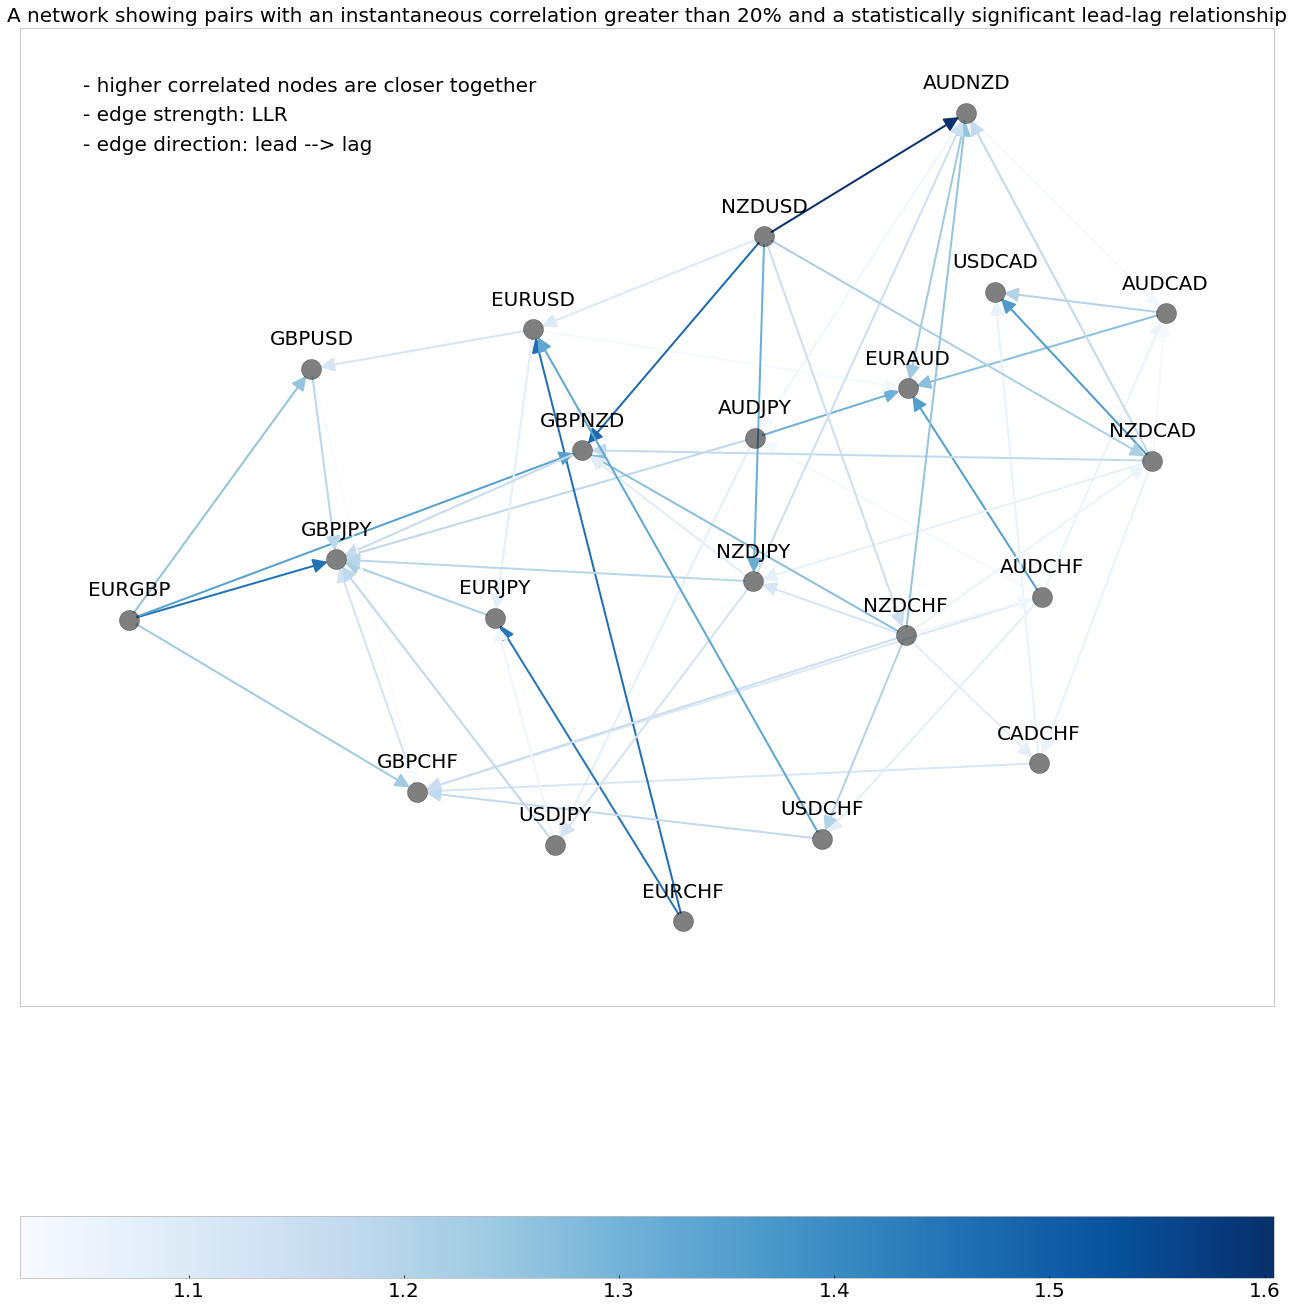

In [124]:
plot_llr_network(symbols)

## Next Steps <a name="next_steps"></a>

Now that we've identified candidate pairs, the next step would be to backtest (in- and out-of-sample) a trading strategy. This strategy would use the historical cross-correlation functions computed above to predict the sign of the  lagger returns a fixed number of ticks ahead based on the leader returns.

Some areas for investigation are:
- Is the strategy profitable after accounting for bid/ask spreads?
- If not, perhaps the strategy has sufficient predictive power to be used as a mid-skew by a market-maker?
- How stationary are these lead-lag relationships? We have aggregated data on a daily-timescale, but perhaps the cross-correlation function should be estimated intra-day?